In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Display the Measurement row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f43610d518>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Display the Station row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f436117080>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

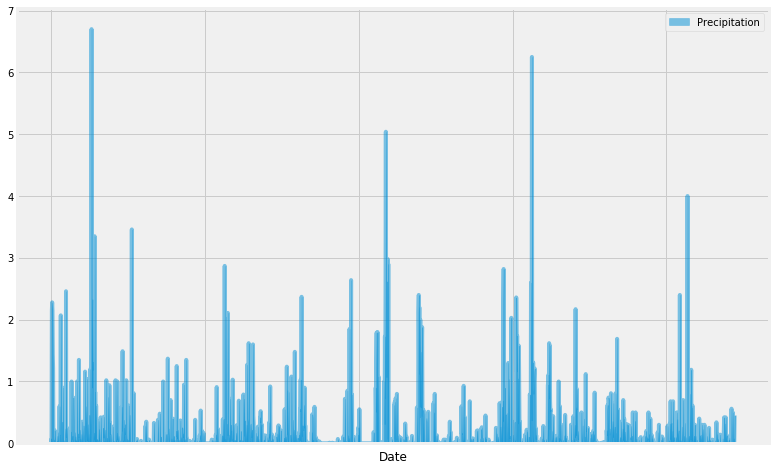

In [12]:
####### Design a query to retrieve the last 12 months of precipitation data and plot the results

# Retrive latest day 
# Convert sqlalchemy return format to date format
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d').date()


## Calculate the date 1 year ago from the latest date. Convert to string
start_date = dt.date(latest_date.year-1, latest_date.month, latest_date.day)
start_date = start_date.strftime('%Y-%m-%d')


## Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > start_date).all()


## Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True, )

## Sort the dataframe by index (=date)
df.sort_index(inplace=True)

## Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.area(stacked=False, figsize=(12,8))

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

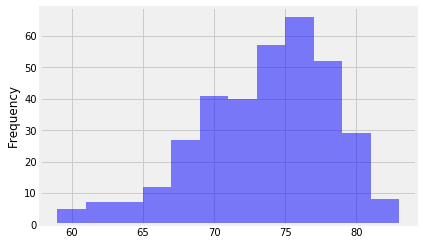

In [17]:
## Choose the station with the highest number of temperature observations.
result = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()

station_observation = result[0]


## Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Retrive latest day. Convert sqlalchemy result format to date format
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d').date()

## Calculate the date 1 year ago from the latest date. Convert to string format
start_date = dt.date(latest_date.year-1, latest_date.month, latest_date.day)
start_date_str = start_date.strftime('%Y-%m-%d')

# Query to read temp observation
results = session.query(Measurement.tobs).\
        filter(Measurement.date > start_date_str).filter(Measurement.station == station_observation).all()

# Read temp observation in to a list
x=[]
for result in results:
    x.append(result[0])

# Plot the histogrm
num_bins = 12
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', label="tobs", alpha=0.5)
plt.ylabel("Frequency")
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
x = calc_temps('2016-09-10', '2016-09-19')
print(x)

[(70.0, 77.3225806451613, 83.0)]


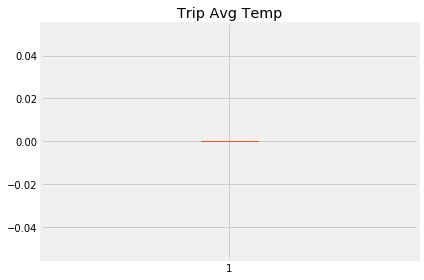

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Load the query into a dataframe, set the index to the date, and plot the ptps
fig, ax = plt.subplots()

x = range(len(x))
ax.boxplot(x, patch_artist=True)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# join statement

# Define start and end dates
start_date = "2018-01-01"
end_date = "2018-01-07"

# Split year, month, date
start_date = start_date.split("-")
end_date = end_date.split("-")

# Find "year", "month-date"(for start vacation) and "month-date"(for end vacation)
year = start_date[0]
start_month_date = f"{start_date[1]}-{start_date[2]}"
end_month_date = f"{end_date[1]}-{end_date[2]}"
    

# (a) Join Measurement and Station tables
# (b) First filter - rows which has previous years record
# (c) Second filter - rows which match vacation "month-date" with previous years "month-date" 
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)]
#sel = [Measurement.date]
result = session.query(*sel).filter(Measurement.station == Station.station).\
                    filter(func.strftime("%Y", Measurement.date) < year).\
                    filter((func.strftime("%m-%d", Measurement.date) >= start_month_date) & \
                            (func.strftime("%m-%d", Measurement.date) <= end_month_date)).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

print(result)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4222222222222221), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.1408928571428571), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.11910714285714284), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.11431372549019604), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.07024999999999999), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04830188679245284), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.061), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.05909090909090909), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.07222222222222223)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#start_date = "2016-09-10"
#end_date = "2016-09-19"

start_date = "2018-01-01"
end_date = "2018-01-07"

# Use the start and end date to create a range of dates
vacation_dates = []

vacation_date_str = start_date
while(True):
    if(vacation_date_str <= end_date):
        vacation_dates.append(vacation_date_str)
    else:
        break
     
    # (a) Convert date from string to datetime.date format
    # (b) Calculate next day
    # (c) Convert the date back from datatime.date format to string format
    vacation_date = dt.datetime.strptime(vacation_date_str, '%Y-%m-%d').date()
    vacation_date = dt.date(vacation_date.year, vacation_date.month, vacation_date.day) + dt.timedelta(days=1)
    vacation_date_str = vacation_date.strftime('%Y-%m-%d')

#print(vacation_dates)


# Stip off the year and save a list of %m-%d strings
month_date = []
for vacation_date in vacation_dates:
    
    # Split Year, Month, Date
    year_month_date = vacation_date.split("-")
    month_date.append(f"{year_month_date[1]}-{year_month_date[2]}")
    
#print(month_date)


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in month_date:
    normals.append(daily_normals(day))

for normal in normals:
    print(normal)

[(62.0, 69.15384615384616, 77.0)]
[(60.0, 69.39622641509433, 77.0)]
[(62.0, 68.9090909090909, 77.0)]
[(58.0, 70.0, 76.0)]
[(56.0, 67.96428571428571, 76.0)]
[(61.0, 68.96491228070175, 76.0)]
[(57.0, 68.54385964912281, 76.0)]


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Save the query results as a Pandas DataFrame and set the index to the date column

# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

# Create a "list-tuple" from "list-list-tuple" 
normal_list = []
for normal in normals:
    normal_list.append(normal[0])
    
# Create dataframe
df1 = pd.DataFrame(normal_list, columns=['TMIN', 'TAVG', 'TMAX'])

# Add Date column
df1["Date"] = vacation_dates

# Set date as a index
df1.set_index('Date', inplace=True)
df1

,TMIN,TAVG,TMAX
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


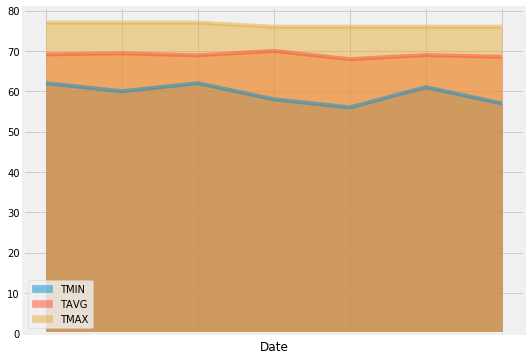

In [25]:
# Plot the daily normals as an area plot with `stacked=False`

ax = df1.plot.area(stacked=False, figsize=(8,6))
